# KZ NOTE:

    3. add an activation (softplus) layer in the end of output layer ---- prevent giving negative values

    2. same as v_1 that early stopping after N_EPOCH//2 

    1. in this version the early stopping tracker only start after 150 epoch.
        but I feel it starts to overfit. In _v2 I'll turn that off and start early stopping after 50 epoch

In [1]:
import time, sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchsummary import summary
import tqdm
from scipy.stats import norm
from scipy.interpolate import interp1d

from compression_nn.preprocess import prepare_data_for_training
from compression_nn.compression_nn import CompressionNN

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False
cudnn.benchmark = True      #May train faster but cost more memory


CUDA Available


In [3]:
STATS = 'WL_23_WPH_short_CMBWL'

GAUSSIAN_AUG_STRENTH = 0.1
BATCH_SIZE           = 16
LEARNING_RATE        = 0.0005
NUM_EPOCH            = 300
WEIGHT_DECAY_RATE    = 0.01
SCHEDULER_FACTOR     = 0.3
SCHEDULER_PATIENCE   = 10


In [4]:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# wph get rid of stuff that's degenerate with wl2 and wl3
# this defines "WPH_short"
mask_l = np.array(16*[ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False])
mask_nbody_wph = np.hstack([np.array([False]*60),np.array([False]*120),mask_l])

# these keys are DVs that don't exist. 
# These indices are defined to select from their corresponding odict ('original dictionary') DVs that do exist
indict2 = dict()
indict2['WL_23_WPH_short'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_3_WPH_short'] = np.concatenate( ( list( range(160, 320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_23_WPH_short_CMBWL'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph], list(range(1076, 1108) )) )
indict2['WPH'] = np.array( range(160, 916))[mask_nbody_wph]
indict2['CMBWL'] = range(160, 192)

odict = dict()
odict['WL_3_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short_CMBWL'] = 'WL_23_WPH_WCMBL'
odict['WPH'] = 'WL_2_WPH'
odict['CMBWL'] = 'WL_2_WCMBL'

for key in odict.keys():
    print(key)
    stat[key] = stat[odict[key]].copy()
    stat[key]['dv'] = stat[key]['dv'][:,indict2[key]]
        

swapind = np.array([0,1,2,3,4,13,14,15,9,10,11,12,5,6,7,8,16])   # om s8 w a e .    ob ns h ...   dm dz

for key in stat.keys():
    stat[key]['params'] = stat[key]['params'][:,swapind]

# defining additional_mask that filters away some extreme values of w, A, eta
parms = stat['WL_2']['params']
extra =   (parms[:,3]<0.8)  & (parms[:,3]>0.2) &\
         (parms[:,4]>0.1) &   (parms[:,4]<0.9) 

additional_mask = (stat['WL_2']['params'][:,2]>0.1)&extra



WL_3_WPH_short
WL_23_WPH_short
WL_23_WPH_short_CMBWL
WPH
CMBWL


In [5]:
# these are the pars/DV that will be used to train the compression (or whatever pre-processing).
pars_train = np.array(stat[STATS]['params'][mask&additional_mask,:16])
dv = np.array(stat[STATS]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on 
    # (so you apply whatever compression/preprocessing to these and give to NDE)
pars_LFI = np.array(stat[STATS]['params'][(~mask)&additional_mask,:16])
dv_LFI = np.array(stat[STATS]['dv'][(~mask)&additional_mask,:])

# Process data; with ZCA whitening

In [6]:
# no normalization

# train only on OMM and S8
pars_train = pars_train[:, 0:2]
pars_LFI = pars_LFI[:, 0:2]

In [7]:
num_samples = len(pars_train)
# split the sample for training ----------
train_split, val_split = int(0.9*num_samples), int(0.1*num_samples)


In [8]:
# Prepare data
train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[:train_split],
    train_y=pars_train[:train_split],
    val_x=dv[train_split:],
    val_y=pars_train[train_split:],
    test_x=dv_LFI,
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening = True
)

In [9]:
train_loader

# Start Training!

In [10]:
# test_id = "v3_test001"

# model = CompressionNN(
#     input_dim=train_loader.dataset.tensors[0].shape[1],
#     output_dim=train_loader.dataset.tensors[1].shape[1],
#     test_id=test_id,
#     output_act=torch.nn.Softplus()
# )

# model.zca = zca

# train_losses, val_losses = model.fit(
#     train_loader=train_loader,
#     val_loader=val_loader,
#     epochs=NUM_EPOCH
# )

In [11]:
hyperparameter_configs = [
#     # less hidden weights; no dropout;
    {
        'test_id': 'v3_test001',
        'hidden_dims': [128, 64, 32],
        'dropout_rate': 0.2
    },
    
    
    # less hidden weights; less layer
    {
        'test_id': 'v3_test002',
        'hidden_dims': [64, 64],
        'dropout_rate': 0.2
    },
    
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act=torch.nn.Softplus()
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH
    )

 54%|█████▍    | 162/300 [04:25<03:46,  1.64s/it]


Early stopping triggered after 163 epochs
Model and preprocessing saved to models/model_v3_test001.pkl


 55%|█████▌    | 166/300 [03:54<03:31,  1.58s/it]

Epoch 166/300:
Training Loss: 0.001599
Validation Loss: 0.001519


 55%|█████▌    | 166/300 [03:56<03:10,  1.42s/it]

Early stopping triggered after 167 epochs
Model and preprocessing saved to models/model_v3_test002.pkl


In [12]:
model.model

RegressionNN(
  (layers): ModuleList(
    (0): Linear(in_features=608, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (batch_norms): ModuleList(
    (0-1): 2 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropouts): ModuleList(
    (0-1): 2 x Dropout(p=0.2, inplace=False)
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
  (activation): ReLU()
  (output_act): Softplus(beta=1.0, threshold=20.0)
)

# plot validations

In [13]:
from compression_nn.utils import plot_test_error

/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.033
 $R^2$ = 0.980
Error S_8 = 8.386


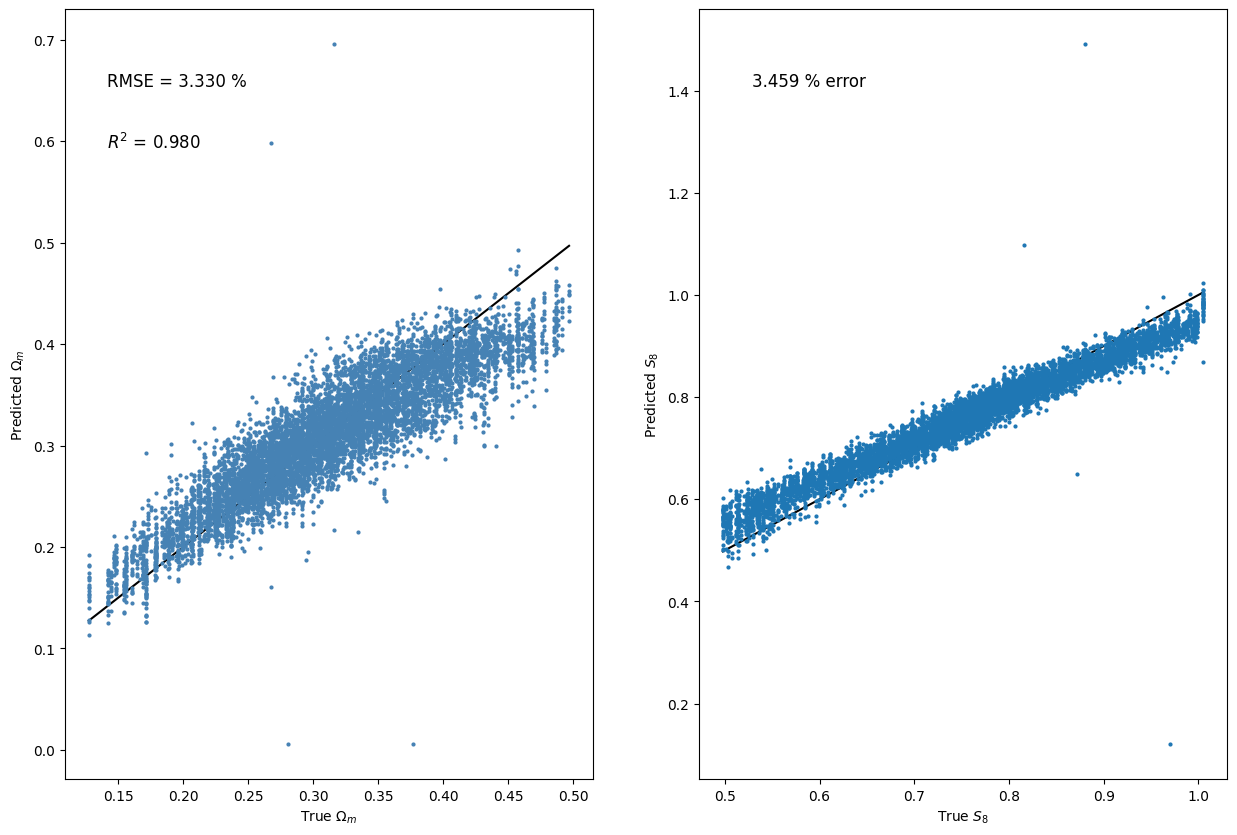

In [14]:
loaded_model = CompressionNN.load('v3_test001')
loaded_model.model.to('cpu')

plot_test_error(loaded_model, test_loader, device='cpu', output=True)


/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.040
 $R^2$ = 0.971
Error S_8 = 9.535


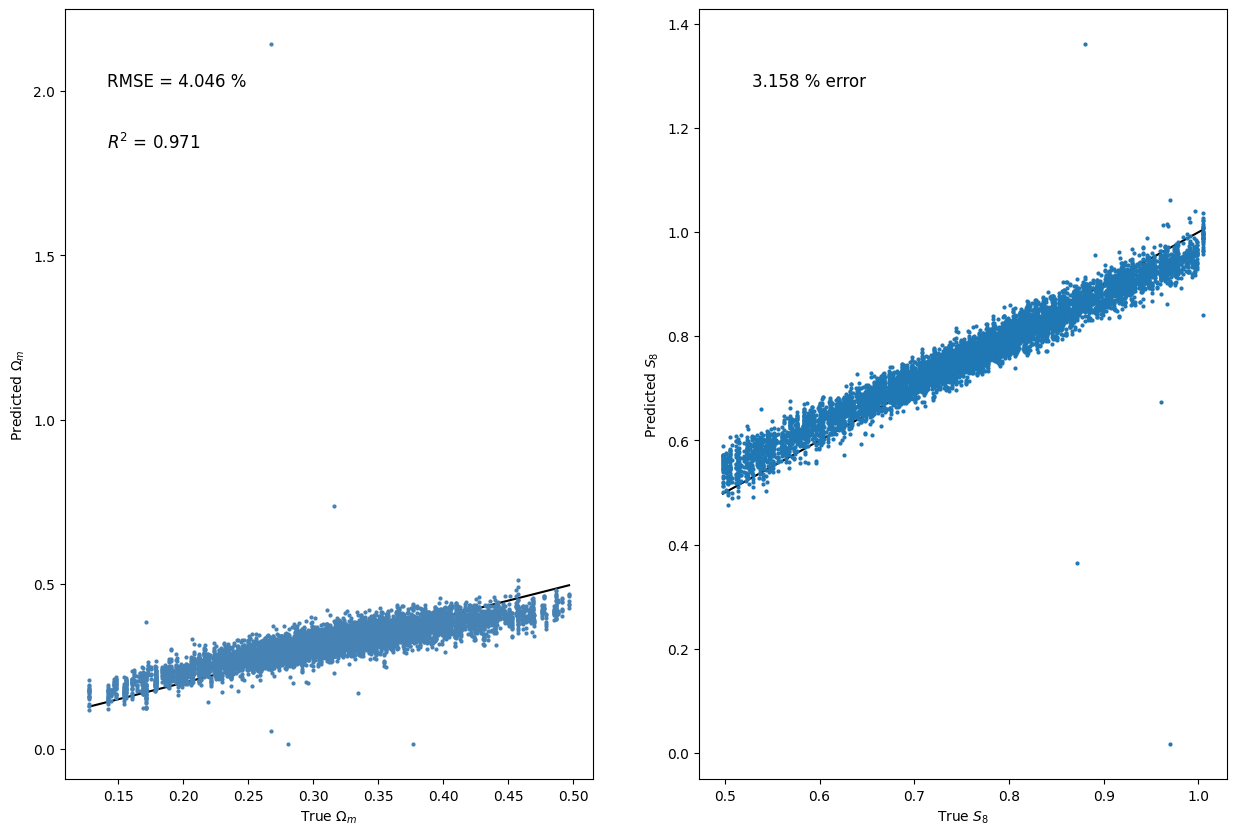

In [15]:
loaded_model = CompressionNN.load('v3_test002')
loaded_model.model.to('cpu')

plot_test_error(loaded_model, test_loader, device='cpu', output=True)
